In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import pandas as pd

import cartopy
import cartopy.crs as ccrs
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, OCEAN, LAKES, BORDERS
import matplotlib.ticker as mticker

### Lecture 23:

- Learn how to plot great and small circles on an equal area net and map projections. 


### Plotting a great circle

In Lecture 21, we learned how to plot directions on equal area and equal angle plots.  Then in Lecture 22, we learned how to calculate the angle between two vectors (using the dot product) and the pole to a plane containing two vectors (using the cross product).  Now, we want to plot the trace of the plane on our equal area net (and it better pass through the two points!).    

Take a look at the module **nets** (you can open it by looking under File and choosing Open).  You will notice the two functions **EqualArea( )** and **EqualAngle( )** from Lecture 21.



In [2]:
import nets as nets 
help(nets)

Help on module nets:

NAME
    nets

FUNCTIONS
    EqualAngle(Pl)
        returns mapped plunge into equal angle projection
    
    EqualArea(Pl)
        returns mapped plunge into equal area projection
    
    cart2dir(X)
    
    dir2cart(Dir)

FILE
    /Users/ltauxe/Documents/writing_stuff/Notebook_GIT/Python_for_Earth_Science_Students/nets.py





Let's re-create our equal area diagram, plot two directions, and plot the pole to the plane containing both directions.

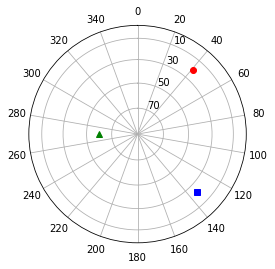

In [3]:
# from Lecture 21
Azs=np.array([40.9,134.1,270.]) # make an array of azimuths
Pls=np.array([20.7,22.5,60.]) # same for plunges
Azs=np.radians(Azs) # convert the azimuths to plunges


fig = plt.subplot(111, polar=True) # Specify polar axes
fig.set_theta_direction(-1) # Reverse direction of degrees (CW)
fig.set_theta_zero_location("N") # Specify 0-degrees as North
plt.polar([0],[90]) ## to scale grid


# nets.EqualArea() converts the plunges to plot coordinates
plt.polar(Azs[0],nets.EqualArea(Pls)[0],'ro') # put on the azimuths and plunges
plt.polar(Azs[1],nets.EqualArea(Pls)[1],'bs') # second one as a blue square

# now let's put on the pole to the plane (from Lecture 22)
plt.polar(Azs[2],nets.EqualArea(Pls)[2],'g^') # third one as a green triangle
# put on the azimuth lines
lines,labels=plt.thetagrids(range(0,360,20),[str(x) for x in range(0,360,20)])
# make the plunge circles and labels
list1=[nets.EqualArea(x) for x in range(10,90,20)] ##don't include center or edge
list2=[str(x) for x in range(10,90,20)]
rlines,rlables=plt.rgrids(list1,list2);

Now, we want to plot the trace of the plane onto the net. We may want to calculate this repeatedly, so let's write a function.  Basically we want to calculate a bunch of points in the plane that trace out the plane in net coordinates.  

This function **pts_on_a_plane( )** will do the trick. The function also calculates small circles. 

In [4]:
# set up rotation matrix
def pts_on_a_plane(pole,gamma=90):
    """
    Calculates directions gamma angle away from a pole.
    
    Parameters: 
    pole: array of azimuth and plunge of the pole
    gamma: desired angle away from the pole, defaults to 90 for great circle
    
    Returns: 
    PTS:  the points on the plane
    """
    
    gamma=np.radians(gamma) # convert gamma to radians
    t=np.zeros((3,3)) # set up a rotation matrix, initialized with zeros.
    t[2]=nets.dir2cart(pole) # assigns the cartesian coordinates of pole to t[2]
    plane1=[pole[0],pole[1]-90.] #  one vector orthogonal to the pole, in the plane
    plane2=[pole[0]+90.,0] # a vector orthogonal to both the pole and plane1
    t[0]=nets.dir2cart(plane1) # assigns this vector's cartesian coordinates to t[0]
    t[1]=nets.dir2cart(plane2)# assigns this vector's cartesian coordinates to t[1]
    t=t.transpose() # takes the transpose
# set up v
    npts=201 # number of points we want in the plane
    xnum=float(npts-1.)/2.
    v=[0,0,0]
    PTS=[] # make a list to keep the data points
    for i in range(npts):  # incremental point along plane
            psi=float(i)*np.pi/xnum
            v[0]=np.sin(gamma)*np.cos(psi)
            v[1]=np.sin(gamma)*np.sin(psi)
            if gamma==np.pi/2.:
                v[2]=0.
            else:
                v[2]=np.sqrt(1.-v[0]**2 - v[1]**2)
            elli=[0,0,0]
# calculate points on the ellipse
            for j in range(3):
                for k in range(3):
                    elli[j]=elli[j] + t[j][k]*v[k]  # cartesian coordinate j of ellipse
            PTS.append(nets.cart2dir(elli))
    return PTS



Now down to the task at hand.  We want to plot the points on our equal area projection 

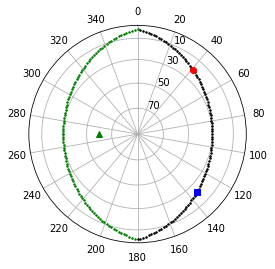

In [5]:
pole=[270.,60.] # direction of the pole (green triangle) from Lecture 22
PTS=pts_on_a_plane(pole) # get the points in the plane orthogonal to the pole
# same as it ever was
fig = plt.subplot(111, polar=True) # Specify polar axes
fig.set_theta_direction(-1) # Reverse direction of degrees (CW)
fig.set_theta_zero_location("N") # Specify 0-degrees as North
plt.polar([0],[90]) ## to scale grid

# now for the points on the plane
for pt in PTS: # step through the points
    if pt[1]<0: # make yellow dots in the upper hemisphere
        plt.polar(np.radians(pt[0]),nets.EqualArea(-pt[1]),'g.',markersize=3)
    else: # make black dots in the lower hemisphere. 
        plt.polar(np.radians(pt[0]),nets.EqualArea(pt[1]),'k.',markersize=3)
        
# put back on the old stuff
plt.polar(Azs[0],nets.EqualArea(Pls)[0],'ro')
plt.polar(Azs[1],nets.EqualArea(Pls)[1],'bs')
plt.polar(Azs[2],nets.EqualArea(Pls)[2],'g^')
lines,labels=plt.thetagrids(range(0,360,20),[str(x) for x in range(0,360,20)])
list1=[nets.EqualArea(x) for x in range(10,90,20)] ##don't include center or edge
list2=[str(x) for x in range(10,90,20)]
rlines,rlables=plt.rgrids(list1,list2)
plt.thetagrids(range(0,360,20),[str(x) for x in range(0,360,20)]);


Whew!  The great circle representing the trace of the plane containing the glacial striations went right through the points representing the striation directions (as it should!).  



Now that we can draw great (and small) circles on projections, it is interesting to compare distortions in various 2D projections of 3D information.  Let's start by comparing the equal area versus equal angle projections.  We can draw a direction with a circle of confidence around it (by settin gamma) on both projections to see how each behaves.  Starting with the equal area projection, let's draw a few directions with 15$^{\circ}$ circles of 95% confidence (our gammas). 

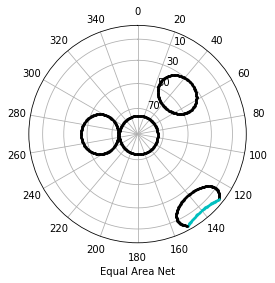

In [6]:
poles=[[270.,60.],[45,45],[135,89],[140,10]] #poles
gamma=15. # circle of confidence
# old stuff
fig = plt.subplot(111, polar=True) # Specify polar axes
fig.set_theta_direction(-1) # Reverse direction of degrees (CW)
fig.set_theta_zero_location("N") # Specify 0-degrees as North
plt.polar([0],[90]) ## to scale grid
for pole in poles: # step through the list of poles
    PTS=pts_on_a_plane(pole,gamma=gamma) # get the points gamma away from this pole
    for pt in PTS:
        if pt[1]<0: # upper hemisphere
            plt.polar(np.radians(pt[0]),nets.EqualArea(-pt[1]),'c.',markersize=3)
        else: # lower hemisphere
            plt.polar(np.radians(pt[0]),nets.EqualArea(pt[1]),'k.',markersize=3)
lines,labels=plt.thetagrids(range(0,360,20),[str(x) for x in range(0,360,20)])
list1=[nets.EqualArea(x) for x in range(10,90,20)] ##don't include center or edge
list2=[str(x) for x in range(10,90,20)]
rlines,rlables=plt.rgrids(list1,list2)
plt.thetagrids(range(0,360,20),[str(x) for x in range(0,360,20)])
plt.xlabel('Equal Area Net');



And the same for the equal angle plot:

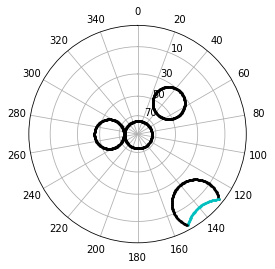

In [7]:
poles=[[270.,60.],[45,45],[135,89],[140,10]]
gamma=15.
fig = plt.subplot(111, polar=True) # Specify polar axes
fig.set_theta_direction(-1) # Reverse direction of degrees (CW)
fig.set_theta_zero_location("N") # Specify 0-degrees as North
plt.polar([0],[90]) ## to scale grid
for pole in poles:
    PTS=pts_on_a_plane(pole,gamma=gamma)
    for pt in PTS:
        if pt[1]<0:
            plt.polar(np.radians(pt[0]),nets.EqualAngle(-pt[1]),'c.',markersize=3)
        else:
            plt.polar(np.radians(pt[0]),nets.EqualAngle(pt[1]),'k.',markersize=3)
lines,labels=plt.thetagrids(range(0,360,20),[str(x) for x in range(0,360,20)])
list1=[nets.EqualAngle(x) for x in range(10,90,20)] ##don't include center or edge
list2=[str(x) for x in range(10,90,20)]
rlines,rlables=plt.rgrids(list1,list2)
plt.thetagrids(range(0,360,20),[str(x) for x in range(0,360,20)]);




Aha!  The equal angle plot plots actual  circles while the equal area plot plots ovals! But the circles in the equal angle plots are all different sizes while the areas of the ovals are the same size.  This just demonstrates the pros and cons of each type of plot.  

Now let's look at some of our map projections and how they perform with respect to distortions.  And yes, once you have the points on the circles, you can plot them on a map, too. 

Here's the mercator projection with a 15$^{\circ}$ circles drawn around San Diego and a around some point in Siberia.   Look at the lecture on maps if you have forgotten how to do this:

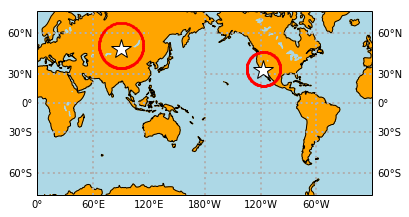

In [8]:
ax = plt.axes(projection=ccrs.Mercator(
    central_longitude=180.0, min_latitude=-70.0, max_latitude=70.0, globe=None))
San_lat=33
San_lon=243  # takes the west longitude and converts to 0=>360
gamma=15.


PTS=np.array(pts_on_a_plane([San_lon,San_lat],gamma)) #making an array lets us transpose later


gl=ax.gridlines(crs=ccrs.PlateCarree(),linewidth=2,linestyle='dotted',draw_labels=True)
gl.xlabels_top = False
gl.ylocator=mticker.FixedLocator(np.arange(-90,91,30))
gl.xlocator=mticker.FixedLocator(np.arange(-180,180,60));
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(OCEAN,color='lightblue')
ax.add_feature(LAND,color='orange')
ax.add_feature(LAKES,color='lightblue')
ax.plot([San_lon],[San_lat],marker='*',color='white',\
        markersize=20,transform=ccrs.Geodetic(),markeredgecolor='black')

x,y=PTS.transpose()[0],PTS.transpose()[1] # this way, I can plot them as x and y arrays.
ax.plot(x,y,'r.',markersize=3,transform=ccrs.Geodetic())


# same for some point in Siberia (90,50)

ax.plot([90],[50],marker='*',color='white',\
        markersize=20,transform=ccrs.Geodetic(),markeredgecolor='black')
PTS=np.array(pts_on_a_plane([90,50],gamma)) 
x,y=PTS.transpose()[0],PTS.transpose()[1] # this way, I can plot them as x and y arrays.
ax.plot(x,y,'r.',markersize=3,transform=ccrs.Geodetic())




ax.set_global()
ax.coastlines();








Compare that with the distortion of a Mollweide projection:

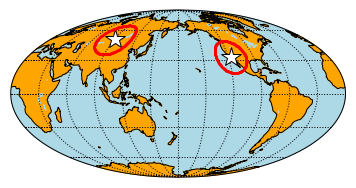

In [9]:
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=180))
San_lat=33
San_lon=-117%360  # takes the west longitude and converts to 0=>360
gl=ax.gridlines(crs=ccrs.PlateCarree(),color='black',linewidth=1,linestyle='dotted')
gl.xlabels_top = False
gl.ylocator=mticker.FixedLocator(np.arange(-90,91,30))
gl.xlocator=mticker.FixedLocator(np.arange(0,400,30));
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(OCEAN,color='lightblue')
ax.add_feature(LAND,color='orange')
ax.add_feature(LAKES,color='lightblue',linewidth=1)
ax.plot([San_lon],[San_lat],marker='*',color='white',\
        markersize=20,transform=ccrs.Geodetic(),markeredgecolor='black')
PTS=np.array(pts_on_a_plane([San_lon,San_lat],gamma))
x,y=PTS.transpose()[0],PTS.transpose()[1] # this way, I can plot them as x and y arrays.
ax.plot(x,y,'r.',markersize=3,transform=ccrs.Geodetic())


# same for some point in Siberia (90,50)

ax.plot([90],[50],marker='*',color='white',\
        markersize=20,transform=ccrs.Geodetic(),markeredgecolor='black')
PTS=np.array(pts_on_a_plane([90,50],gamma))
x,y=PTS.transpose()[0],PTS.transpose()[1] # this way, I can plot them as x and y arrays.
ax.plot(x,y,'r.',markersize=3,transform=ccrs.Geodetic())

ax.set_global()


ax.coastlines();




One squishes horizontally while the other squishes vertically. 

One more thing - recall the lecture when we looked at P and S wave arrivals and calculated the great circle distance between the source and receiver?  There was this map: 

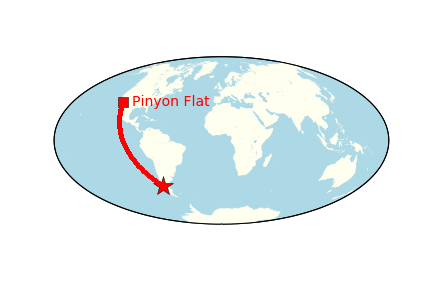

In [10]:
Image(filename='Figures/greatCirc.png')

Now  you can make this map yourself putting together tricks from finding the pole to two vectors, finding the great circle using spherical trigonometry and plotting the line on a Mollweide projection.  

In [11]:
def find_pole(pt1,pt2):
    """
    Calculate the pole for two vectors
    
    inputs:
        pt1-  [Azimuth, plunge] a list containing the azimuth
                                and plunge of the first point
        pt2-  [Azimuth, plunge] a list containing the azimuth 
                                and plunge of the second point
    returns:
             [Azimuth, plunge] of the pole 
    """
    vec1=nets.dir2cart(pt1)
    vec2=nets.dir2cart(pt2)
    pole=np.cross(vec1,vec2)
    return nets.cart2dir(pole)

def great_circle(lat_1,lon_1,lat_2,lon_2):
    """
    inputs:
       lat_1 - latitude of the starting point in degrees
       lon_1 - longitude of the starting point in degrees
       lat_2 - latitude of the ending point in degrees
       lon_2 - longitude of the ending point in degrees
       
    returns:
       great circle distance between the two points
       
    """
    # first we have to convert the latitudes to colatitudes:
    colat_1,colat_2=90.-lat_1,90.-lat_2
    # and alpha is the difference betwee the two longitudes
    alpha=(lon_2-lon_1)%360
    # Then lets make life easy on us and convert degrees to radians
    colat_1,colat_2,alpha= np.radians(colat_1),\
              np.radians(colat_2),np.radians(alpha)# continued line from above
    a=np.arccos(np.cos(colat_1)*np.cos(colat_2)+np.sin(colat_1)*np.sin(colat_2)*np.cos(alpha))
    # remember to convert back to degrees! 
    return np.degrees(a)  



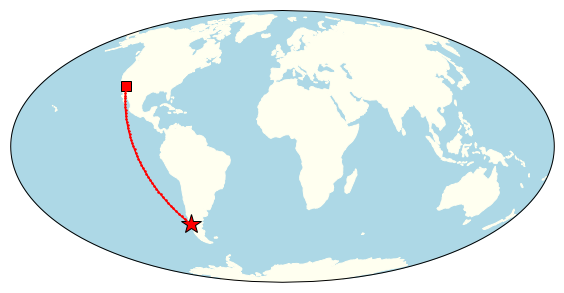

In [12]:
plt.figure(1,(10,5)) # make a nice big plot

PF_lat,PF_lon=33.3,-115.7
EQ_lat,EQ_lon=-43.42,-73.95
lons=[EQ_lon,PF_lon]
lats=[EQ_lat,PF_lat]


ax = plt.axes(projection=ccrs.Mollweide(central_longitude=0))
ax.add_feature(OCEAN,color='lightblue')
ax.add_feature(LAND,color='ivory')

ax.plot([EQ_lon],[EQ_lat],marker='*',color='red',\
        markersize=20,transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot([PF_lon],[PF_lat],marker='s',color='red',\
        markersize=10,transform=ccrs.Geodetic(),markeredgecolor='black')

pole= find_pole([EQ_lon,EQ_lat],[PF_lon,PF_lat])
pts=pts_on_a_plane(pole,90.)
newx,newy=[],[]

for pt in pts: 
    if  PF_lon%360 <pt[0] and (pt[0]<EQ_lon%360):
        newx.append(pt[0])
        newy.append(pt[1])

ax.plot(newx,newy,marker='.',color='red',markersize=3,transform=ccrs.Geodetic()) 
ax.set_global();